# First contact with Cassandra
This notebook will show the basics of how to push and extract data from Cassandra distributed No-SQL database

#### References
* https://datastax.github.io/python-driver/
* http://datastax.github.io/python-driver/getting_started.html
* https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
* https://datastax.github.io/python-driver/getting_started.html
* https://towardsdatascience.com/getting-started-with-apache-cassandra-and-python-81e00ccf17c9
* https://stackoverflow.com/questions/36606441/counting-rows-in-column-family-of-cassandra-using-python-driver

In [1]:
import os
# Cassandra Stuff
from cassandra.cluster import Cluster
import cassandra.util
import uuid

import numpy as np
import pickle
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import sat_utils

# Insert String (SQL)
insert_string = """
    INSERT INTO satseg (id, image, label, name, filename)
    VALUES (%s, %s, %s, %s, %s)
"""

#### Get Some Data to Push to Cassandra Cluster

In [2]:
X = sat_utils.read_pickle_data('./data/input.pickle')
Y = sat_utils.read_pickle_data('./data/label.pickle')
# Convert dictionaries to numpy array
X = np.stack([x for x in X.values()])
Y = np.stack([x for x in Y.values()])
print('X:', X.shape)
print('Y:', Y.shape)

X: (16820, 8, 76, 76)
Y: (16820, 3, 76, 76)


#### Connect to Cassandra Cluster

In [3]:
# Considering that the cluster is on localhost
cassandra_port = int(os.environ['PORT_1'])
cluster = Cluster([os.environ['BOLT_HOST_IP_ADDRESS']], port = cassandra_port)
# Other option if you know the IPs
# cluster = Cluster(['192.168.0.1', '192.168.0.2'])
# Get a session to the database
session = cluster.connect('mydb')
# Save Cassandra Row Factory
default_row_factory = session.row_factory

#### Insert Data

In [4]:
for idx in tqdm(range(X.shape[0]), desc='Pushing Data'):
    image = X[idx,:,:,:].tobytes()
    label = Y[idx,:,:,:].tobytes()
    # Insert into database
    session.execute(insert_string,(uuid.uuid1(), image, label, 'NotDef', 'Paris'))

Pushing Data:  47%|████▋     | 7873/16820 [07:07<09:41, 15.39it/s]

KeyboardInterrupt: 

#### Get some Data from the Database

Columns: ['id', 'filename', 'image', 'label', 'name']
Label: Paris


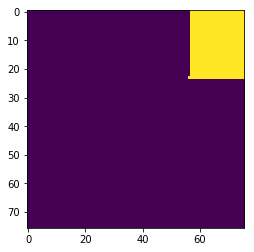

Label: Paris


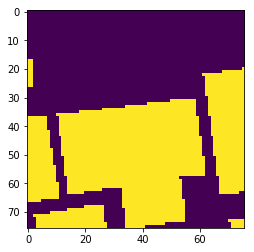

In [5]:
session.row_factory = default_row_factory
rows = session.execute('SELECT * FROM satseg WHERE filename=\'Paris\' limit 2')
print('Columns:',rows.column_names)
for row in rows:
    # Convert byte stream back to numpy array
    label = np.frombuffer(row.label, dtype=np.float32).reshape(3,76,76)
    print('Label:', row.filename)
    plt.imshow(label[0,:,:])
    plt.show()

#### Very Bad way to count number of rows

In [7]:
rows = session.execute('SELECT COUNT(*) FROM satseg')
print('Columns:',rows.column_names)
for row in rows:
    print(row.count)

ReadFailure: Error from server: code=1300 [Replica(s) failed to execute read] message="Operation failed - received 0 responses and 1 failures" info={'consistency': 'LOCAL_ONE', 'required_responses': 1, 'received_responses': 0, 'failures': 1}